In [32]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import random
import shutil
import cv2
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

In [17]:
# Set the path to the directory containing images
image_folder_path = 'images'
train_folder_path = 'path_to_train_folder'
validation_folder_path = 'path_to_validation_folder'

# Create directories if they don't exist
os.makedirs(train_folder_path, exist_ok=True)
os.makedirs(validation_folder_path, exist_ok=True)

# Define the image extensions you want to include
image_extensions = ['jpg', 'jpeg', 'png', 'bmp', 'tiff']

# Create a list to store the paths of all image files in the directory
image_files = []

# Iterate over each image extension and add the matching files to the list
for ext in image_extensions:
    image_files.extend(glob.glob(os.path.join(image_folder_path, f'*.{ext}')))

# Shuffle the image files
random.shuffle(image_files)

# Calculate the split index
split_index = int(len(image_files) * 0.8)  # 80% training, 20% validation

# Split the image files
train_files = image_files[:split_index]
validation_files = image_files[split_index:]

# Function to copy files to their respective directories
def copy_files(file_list, destination_folder):
    for file in file_list:
        shutil.copy(file, destination_folder)

# Copy the training files
copy_files(train_files, train_folder_path)

# Copy the validation files
copy_files(validation_files, validation_folder_path)

print(f'Total images: {len(image_files)}')
print(f'Training set: {len(train_files)} images')
print(f'Validation set: {len(validation_files)} images')


Total images: 27
Training set: 21 images
Validation set: 6 images


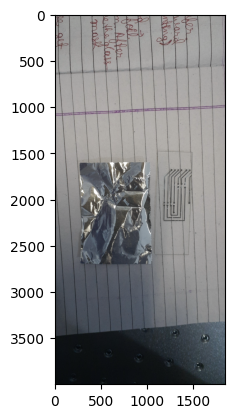

In [18]:
image = cv2.imread('images/20230409_232901.jpg')
plt.imshow(image)

In [21]:
degraded_train_folder_path = 'path_to_degraded_train_folder'
degraded_validation_folder_path = 'path_to_degraded_validation_folder'

# Create directories if they don't exist
os.makedirs(degraded_train_folder_path, exist_ok=True)
os.makedirs(degraded_validation_folder_path, exist_ok=True)
def degrade_image(image):
    # Convert to float32 for more precise operations
    image = np.float32(image)

    # Change contrast and brightness
    alpha = random.uniform(0.5, 1.5)  # Contrast control (1.0-3.0)
    beta = random.uniform(-50, 50)    # Brightness control (0-100)
    image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

    # Add Gaussian blur
    ksize = random.choice([3, 5, 7])  # Kernel size (odd numbers)
    image = cv2.GaussianBlur(image, (ksize, ksize), 0)

    # Add Gaussian noise
    row, col, ch = image.shape
    mean = 0
    sigma = random.uniform(5, 20)
    gauss = np.random.normal(mean, sigma, (row, col, ch))
    noisy_image = image + gauss.reshape(row, col, ch)
    noisy_image = np.clip(noisy_image, 0, 255)  # Ensure pixel values are within [0, 255]

    return np.uint8(noisy_image)


In [22]:
def process_and_save_images(src_folder, dest_folder):
    # List all image files in the source folder
    image_files = glob.glob(os.path.join(src_folder, '*'))

    for image_file in image_files:
        # Load the image
        image = cv2.imread(image_file)
        
        # Check if the image was loaded successfully
        if image is not None:
            # Degrade the image
            degraded_image = degrade_image(image)
            
            # Save the degraded image
            file_name = os.path.basename(image_file)
            dest_path = os.path.join(dest_folder, file_name)
            cv2.imwrite(dest_path, degraded_image)
        else:
            print(f'Failed to load image: {image_file}')

# Process and save degraded images for training and validation sets
process_and_save_images(train_folder_path, degraded_train_folder_path)
process_and_save_images(validation_folder_path, degraded_validation_folder_path)


In [28]:
degraded_train_folder_path = 'path_to_degraded_train_folder'
original_train_folder_path = 'path_to_train_folder'
degraded_validation_folder_path = 'path_to_degraded_validation_folder'
original_validation_folder_path = 'path_to_validation_folder'

# Patch size
patch_size = 3  # Example for 3x3 patches

# Number of patches to extract per image
num_patches = 50  # Adjust based on your requirement

def extract_random_patches(degraded_image, original_image, patch_size, num_patches):
    patches = []
    central_pixels = []
    img_height, img_width = degraded_image.shape[:2]
    patch_half = patch_size // 2
    
    for _ in range(num_patches):
        # Randomly choose the top-left corner of the patch ensuring the patch fits within the image
        x = random.randint(patch_half, img_width - patch_half - 1)
        y = random.randint(patch_half, img_height - patch_half - 1)
        
        # Extract the patch from the degraded image
        patch = degraded_image[y-patch_half:y+patch_half+1, x-patch_half:x+patch_half+1]
        
        # Get the central pixel from the original image
        central_pixel = original_image[y, x]
        
        # Flatten the patch and append to the list
        patches.append(patch.flatten())
        
        # Append the central pixel value
        central_pixels.append(central_pixel.flatten())
    
    return patches, central_pixels



In [29]:
def process_images(degraded_folder, original_folder, patch_size, num_patches):
    patches = []
    central_pixels = []
    
    # List all image files in the degraded folder
    degraded_files = glob.glob(os.path.join(degraded_folder, '*'))
    
    for degraded_file in degraded_files:
        # Load the degraded image
        degraded_image = cv2.imread(degraded_file)
        
        # Find the corresponding original image file
        file_name = os.path.basename(degraded_file)
        original_file = os.path.join(original_folder, file_name)
        
        # Load the original image
        original_image = cv2.imread(original_file)
        
        # Check if both images are loaded successfully
        if degraded_image is not None and original_image is not None:
            # Extract patches and central pixels
            img_patches, img_central_pixels = extract_random_patches(degraded_image, original_image, patch_size, num_patches)
            
            # Append to the overall list
            patches.extend(img_patches)
            central_pixels.extend(img_central_pixels)
        else:
            print(f'Failed to load images: {degraded_file} or {original_file}')
    
    return np.array(patches), np.array(central_pixels)

# Process training images
train_patches, train_central_pixels = process_images(degraded_train_folder_path, original_train_folder_path, patch_size, num_patches)

# Process validation images
validation_patches, validation_central_pixels = process_images(degraded_validation_folder_path, original_validation_folder_path, patch_size, num_patches)


In [110]:
# Create SVR models for each channel
svr_r = make_pipeline(StandardScaler(), SVR(kernel='rbf', C=11, epsilon=0.001, gamma='scale'))
svr_g = make_pipeline(StandardScaler(), SVR(kernel='rbf', C=11, epsilon=0.0001, gamma='scale'))
svr_b = make_pipeline(StandardScaler(), SVR(kernel='rbf', C=11, epsilon=0.001, gamma='scale'))

# Train the models
svr_r.fit(train_patches, train_central_pixels[:, 0])
svr_g.fit(train_patches, train_central_pixels[:, 1])
svr_b.fit(train_patches, train_central_pixels[:, 2])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(C=11, epsilon=0.001))])

In [111]:
# Predict using the models
val_pred_r = svr_r.predict(validation_patches)
val_pred_g = svr_g.predict(validation_patches)
val_pred_b = svr_b.predict(validation_patches)

# Combine predictions
val_pred = np.stack([val_pred_r, val_pred_g, val_pred_b], axis=1)

# Calculate mean squared error
mse_r = mean_squared_error(validation_central_pixels[:, 0], val_pred_r)
mse_g = mean_squared_error(validation_central_pixels[:, 1], val_pred_g)
mse_b = mean_squared_error(validation_central_pixels[:, 2], val_pred_b)

print(f'Validation MSE (R channel): {mse_r}')
print(f'Validation MSE (G channel): {mse_g}')
print(f'Validation MSE (B channel): {mse_b}')

Validation MSE (R channel): 1003.9449112658868
Validation MSE (G channel): 996.4174924873632
Validation MSE (B channel): 1004.4842616492132


In [122]:
def restore_image_batch(degraded_image, svr_r, svr_g, svr_b, patch_size):
    restored_image = np.zeros_like(degraded_image)
    patch_half = patch_size // 2
    img_height, img_width, _ = degraded_image.shape

    patches = []
    positions = []

    for y in range(patch_half, img_height - patch_half):
        for x in range(patch_half, img_width - patch_half):
            patch = degraded_image[y-patch_half:y+patch_half+1, x-patch_half:x+patch_half+1].flatten()
            if patch.size == patch_area:
                patches.append(patch)
                positions.append((y, x))

    patches = np.array(patches)

    # Predict in batches
    pred_r = svr_r.predict(patches)
    pred_g = svr_g.predict(patches)
    pred_b = svr_b.predict(patches)

    for i, (y, x) in enumerate(positions):
        restored_image[y, x] = [pred_r[i], pred_g[i], pred_b[i]]

    return np.clip(restored_image, 0, 255).astype(np.uint8)


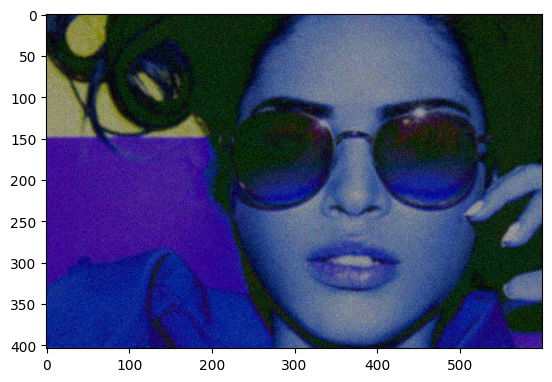

In [123]:
test_image = cv2.imread('images/MediumResolutionImage.png')
degraded_image = degrade_image(test_image)
plt.imshow(degraded_image)

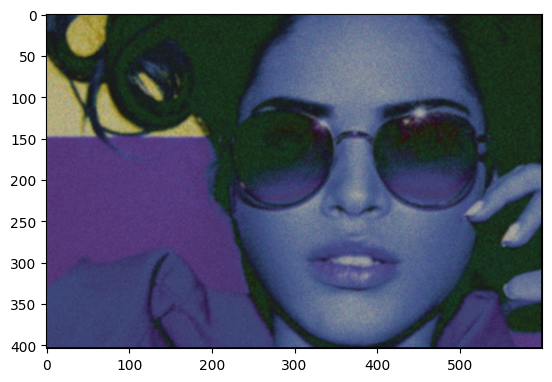

In [124]:
image_restored = restore_image(degraded_image, svr_r, svr_g, svr_b, 3)
plt.imshow(image_restored)

(-0.5, 599.5, 403.5, -0.5)

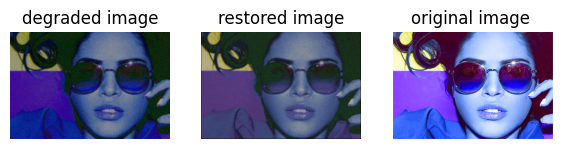

In [127]:
plt.figure(figsize = [7,7])
plt.subplot(131)
plt.title('degraded image')
plt.imshow(degraded_image)
plt.axis('off')

plt.subplot(132)
plt.title('restored image')
plt.imshow(image_restored) 
plt.axis('off')

plt.subplot(133)
plt.title('original image ')
plt.imshow(test_image) 
plt.axis('off')
